<div style="text-align: center; line-height: 0; padding-top: 2px;">
  <img src="https://www.quantiaconsulting.com/logos/quantia_logo_orizz.png" alt="Quantia Consulting" style="width: 600px; height: 250px">
</div>

# Final Challenge A - Solution
---

## Using the KDDCup dataset, find the best SML model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

The KDDCup intrusion detection data stream records intrusions simulated in a military network environment. The task is to classify network traffic into **normal** (80.31% of the cases) or some kind of **intrusion** (19.69% of the cases) described by *41 features*, of which *34 numeric* and *7 nominal*. The problem of temporal dependence is particularly evident here. Inspecting the raw stream confirms that there are time periods of intrusions rather than single instances of intrusions.
The *7 nominal* attributes are:
- protocol_type
- service
- flag
- land
- logged_in
- is_host_login
- is_guest_login

**Class:** `class` | 0: normal, 1: intrusion
 
**Samples:** 494021


In [2]:
df = pd.read_csv("../datasets/KDDCup.csv")
features = df.columns[:-1]
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

## Plot data distribution
---
Encode the protocol_type, service and flag attributes and apply the **PCA**

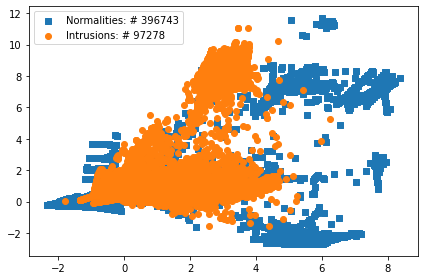

In [3]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

encoder = OrdinalEncoder()
encDf = df.copy()
encDf[["protocol_type","service","flag"]] = encoder.fit_transform(encDf[["protocol_type","service","flag"]])


features = encDf.drop(["class"],axis=1)
label = encDf["class"]

scaled_features = StandardScaler().fit_transform(features)
num_components = 2
pca = PCA(n_components=num_components)
pca_data = pca.fit_transform(scaled_features)
pca_data.shape

pc_df = pd.DataFrame(data = pca_data,columns = ["pc1", "pc2"])
pc_df["class"] = label

normalities = pc_df[pc_df["class"] == 0]
intrusions = pc_df[pc_df["class"] == 1]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x=normalities["pc1"], y=normalities["pc2"], marker="s", label='Normalities: # ' + str(normalities.shape[0]))
ax1.scatter(x=intrusions["pc1"], y=intrusions["pc2"], marker="o", label='Intrusions: # ' + str(intrusions.shape[0]))
plt.legend(loc='upper left');
fig.tight_layout()
plt.show()

## Find the best SML model!
---
### Hint
Since the stream is imbalances, the Accuracy is not a reliable metric. Try using [BalancedAccuracy](https://riverml.xyz/latest/api/metrics/BalancedAccuracy/) and [GeometricMean](https://riverml.xyz/latest/api/metrics/GeometricMean/) instead. To combine them, use [Metrics](https://riverml.xyz/latest/api/metrics/Metrics/)

In [4]:
from river.stream import iter_pandas
from river.evaluate import progressive_val_score
from river.metrics import Metrics,Accuracy,BalancedAccuracy,GeometricMean,CohenKappa
from river import compose

## Naïve Bayes

In [5]:
from river.naive_bayes import GaussianNB

model = (
    compose.Discard('protocol_type','service', 'flag') |
    GaussianNB()
)
features = df.columns[:-1]
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=50000)

[50,000] Accuracy: 87.08%, BalancedAccuracy: 79.69%, GeometricMean: 78.41%, CohenKappa: 62.68%
[100,000] Accuracy: 88.41%, BalancedAccuracy: 88.58%, GeometricMean: 88.57%, CohenKappa: 76.62%
[150,000] Accuracy: 88.25%, BalancedAccuracy: 87.94%, GeometricMean: 87.71%, CohenKappa: 76.31%
[200,000] Accuracy: 91.19%, BalancedAccuracy: 89.05%, GeometricMean: 88.74%, CohenKappa: 80.26%
[250,000] Accuracy: 92.95%, BalancedAccuracy: 89.54%, GeometricMean: 89.19%, CohenKappa: 82.05%
[300,000] Accuracy: 94.13%, BalancedAccuracy: 89.82%, GeometricMean: 89.45%, CohenKappa: 83.08%
[350,000] Accuracy: 93.71%, BalancedAccuracy: 87.85%, GeometricMean: 87.22%, CohenKappa: 80.52%
[400,000] Accuracy: 94.34%, BalancedAccuracy: 87.82%, GeometricMean: 87.17%, CohenKappa: 80.83%
[450,000] Accuracy: 94.93%, BalancedAccuracy: 87.82%, GeometricMean: 87.13%, CohenKappa: 81.13%


Accuracy: 93.28%, BalancedAccuracy: 84.92%, GeometricMean: 83.79%, CohenKappa: 76.68%

## Hoeffding Adaptive Tree

In [6]:
from river.tree import HoeffdingAdaptiveTreeClassifier

model = HoeffdingAdaptiveTreeClassifier(nominal_attributes=['protocol_type','service', 'flag'], seed=42)
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream, 
                      model=model, 
                      metric=metrics, 
                      print_every=50000)

[50,000] Accuracy: 99.31%, BalancedAccuracy: 98.77%, GeometricMean: 98.77%, CohenKappa: 98.11%
[100,000] Accuracy: 99.28%, BalancedAccuracy: 99.24%, GeometricMean: 99.24%, CohenKappa: 98.54%
[150,000] Accuracy: 98.91%, BalancedAccuracy: 98.92%, GeometricMean: 98.92%, CohenKappa: 97.81%
[200,000] Accuracy: 99.18%, BalancedAccuracy: 99.17%, GeometricMean: 99.17%, CohenKappa: 98.21%
[250,000] Accuracy: 99.34%, BalancedAccuracy: 99.29%, GeometricMean: 99.29%, CohenKappa: 98.39%
[300,000] Accuracy: 99.45%, BalancedAccuracy: 99.35%, GeometricMean: 99.35%, CohenKappa: 98.49%
[350,000] Accuracy: 99.39%, BalancedAccuracy: 99.29%, GeometricMean: 99.29%, CohenKappa: 98.23%
[400,000] Accuracy: 99.42%, BalancedAccuracy: 99.28%, GeometricMean: 99.28%, CohenKappa: 98.18%
[450,000] Accuracy: 99.47%, BalancedAccuracy: 99.27%, GeometricMean: 99.27%, CohenKappa: 98.17%


Accuracy: 99.42%, BalancedAccuracy: 99.26%, GeometricMean: 99.26%, CohenKappa: 98.17%

## Adaptive Random Forest

In [7]:
from river.ensemble import AdaptiveRandomForestClassifier

model = AdaptiveRandomForestClassifier(n_models=5,nominal_attributes=['protocol_type','service', 'flag'])
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=50000)

[50,000] Accuracy: 99.81%, BalancedAccuracy: 99.68%, GeometricMean: 99.68%, CohenKappa: 99.47%
[100,000] Accuracy: 99.76%, BalancedAccuracy: 99.74%, GeometricMean: 99.74%, CohenKappa: 99.51%
[150,000] Accuracy: 99.68%, BalancedAccuracy: 99.68%, GeometricMean: 99.68%, CohenKappa: 99.35%
[200,000] Accuracy: 99.76%, BalancedAccuracy: 99.76%, GeometricMean: 99.76%, CohenKappa: 99.47%
[250,000] Accuracy: 99.81%, BalancedAccuracy: 99.80%, GeometricMean: 99.80%, CohenKappa: 99.52%
[300,000] Accuracy: 99.84%, BalancedAccuracy: 99.82%, GeometricMean: 99.82%, CohenKappa: 99.55%
[350,000] Accuracy: 99.84%, BalancedAccuracy: 99.81%, GeometricMean: 99.81%, CohenKappa: 99.55%
[400,000] Accuracy: 99.85%, BalancedAccuracy: 99.80%, GeometricMean: 99.80%, CohenKappa: 99.53%
[450,000] Accuracy: 99.87%, BalancedAccuracy: 99.81%, GeometricMean: 99.81%, CohenKappa: 99.54%


Accuracy: 99.84%, BalancedAccuracy: 99.79%, GeometricMean: 99.79%, CohenKappa: 99.50%

## ADWIN Online Bagging

In [8]:
from river.ensemble import ADWINBaggingClassifier
from river.tree import HoeffdingTreeClassifier

model = ADWINBaggingClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['protocol_type','service', 'flag']),
                          n_models=5,
                          seed=42)
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=50000)


[50,000] Accuracy: 99.57%, BalancedAccuracy: 99.22%, GeometricMean: 99.22%, CohenKappa: 98.83%
[100,000] Accuracy: 99.20%, BalancedAccuracy: 99.15%, GeometricMean: 99.15%, CohenKappa: 98.37%
[150,000] Accuracy: 98.97%, BalancedAccuracy: 99.00%, GeometricMean: 98.99%, CohenKappa: 97.95%
[200,000] Accuracy: 99.23%, BalancedAccuracy: 99.27%, GeometricMean: 99.27%, CohenKappa: 98.33%
[250,000] Accuracy: 99.38%, BalancedAccuracy: 99.39%, GeometricMean: 99.39%, CohenKappa: 98.49%
[300,000] Accuracy: 99.49%, BalancedAccuracy: 99.46%, GeometricMean: 99.46%, CohenKappa: 98.59%
[350,000] Accuracy: 99.40%, BalancedAccuracy: 99.32%, GeometricMean: 99.32%, CohenKappa: 98.27%
[400,000] Accuracy: 99.39%, BalancedAccuracy: 99.15%, GeometricMean: 99.15%, CohenKappa: 98.07%
[450,000] Accuracy: 99.41%, BalancedAccuracy: 99.05%, GeometricMean: 99.05%, CohenKappa: 97.97%


Accuracy: 99.36%, BalancedAccuracy: 99.09%, GeometricMean: 99.09%, CohenKappa: 97.99%

## Leveraging Bagging

In [10]:
from river.ensemble import LeveragingBaggingClassifier
from river.tree import HoeffdingTreeClassifier

model = LeveragingBaggingClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['protocol_type','service', 'flag']),
                          n_models=5,
                          seed=42)
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=50000)

[50,000] Accuracy: 99.69%, BalancedAccuracy: 99.50%, GeometricMean: 99.50%, CohenKappa: 99.16%
[100,000] Accuracy: 99.67%, BalancedAccuracy: 99.65%, GeometricMean: 99.65%, CohenKappa: 99.33%
[150,000] Accuracy: 99.47%, BalancedAccuracy: 99.48%, GeometricMean: 99.48%, CohenKappa: 98.94%
[200,000] Accuracy: 99.60%, BalancedAccuracy: 99.61%, GeometricMean: 99.61%, CohenKappa: 99.14%
[250,000] Accuracy: 99.68%, BalancedAccuracy: 99.67%, GeometricMean: 99.67%, CohenKappa: 99.22%
[300,000] Accuracy: 99.74%, BalancedAccuracy: 99.70%, GeometricMean: 99.70%, CohenKappa: 99.27%
[350,000] Accuracy: 99.72%, BalancedAccuracy: 99.66%, GeometricMean: 99.66%, CohenKappa: 99.20%
[400,000] Accuracy: 99.72%, BalancedAccuracy: 99.64%, GeometricMean: 99.64%, CohenKappa: 99.11%
[450,000] Accuracy: 99.75%, BalancedAccuracy: 99.64%, GeometricMean: 99.64%, CohenKappa: 99.12%


Accuracy: 99.73%, BalancedAccuracy: 99.65%, GeometricMean: 99.65%, CohenKappa: 99.16%

## Streaming Random Patches

In [11]:
from river.ensemble import SRPClassifier
from river.tree import HoeffdingTreeClassifier
from river.drift import ADWIN

model = SRPClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['protocol_type','service', 'flag']),
                      n_models=5,
                      drift_detector=ADWIN(delta=0.001),
                      warning_detector=ADWIN(delta=0.01),
                      seed=42)
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream, 
                      model=model, 
                      metric=metrics, 
                      print_every=50000)

[50,000] Accuracy: 99.75%, BalancedAccuracy: 99.51%, GeometricMean: 99.51%, CohenKappa: 99.30%
[100,000] Accuracy: 99.64%, BalancedAccuracy: 99.61%, GeometricMean: 99.61%, CohenKappa: 99.27%
[150,000] Accuracy: 99.39%, BalancedAccuracy: 99.41%, GeometricMean: 99.41%, CohenKappa: 98.78%
[200,000] Accuracy: 99.54%, BalancedAccuracy: 99.57%, GeometricMean: 99.57%, CohenKappa: 99.01%
[250,000] Accuracy: 99.64%, BalancedAccuracy: 99.64%, GeometricMean: 99.64%, CohenKappa: 99.11%
[300,000] Accuracy: 99.70%, BalancedAccuracy: 99.69%, GeometricMean: 99.69%, CohenKappa: 99.16%
[350,000] Accuracy: 99.67%, BalancedAccuracy: 99.63%, GeometricMean: 99.63%, CohenKappa: 99.04%
[400,000] Accuracy: 99.69%, BalancedAccuracy: 99.63%, GeometricMean: 99.63%, CohenKappa: 99.03%
[450,000] Accuracy: 99.72%, BalancedAccuracy: 99.62%, GeometricMean: 99.62%, CohenKappa: 99.03%


Accuracy: 99.71%, BalancedAccuracy: 99.63%, GeometricMean: 99.63%, CohenKappa: 99.09%